# The Fokker Planck LID estimator

Here we rigorously test the Fokker Planck estimators (including both rapid and regression-based estimators). Here, we consider two scenarios: 
1. In the first case, we don't train a model. We take a look at the `VpSdeGaussianAnalytical` class, which is a class where the marginal distribution is known analytically. We compare the Fokker Planck estimators with the analytical solution.
2. In the second case, we train a model and compare the Fokker Planck estimators with the regression-based estimator, the dataset that we use in this case is the Lollipop dataset.

Start off by doing the necessary imports.

In [1]:
from notebook_setup import device

import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

%load_ext autoreload
%autoreload 2
from models.diffusions.sdes import VpSde

from models.diffusions.sdes.utils import VpSdeGaussianAnalytical
from data.distributions import Lollipop
from lid.diffusions import FlipdEstimator, FPRegressEstimator


# NOTE: this code uses GPU, so make sure to run it on a GPU-enabled machine and set the correct device
device = torch.device('cuda:0')

## Scenario 1: No need to train a diffusion model

This case is the perfect scenario to test the Fokker Planck estimators. We have a known analytical solution for the marginal distribution. We can compare the Fokker Planck estimators with the analytical solution. In this case, we assume that the data distribution comes from a Gaussian multivariate distribution with covariance eigenvalues that are of different scales. In particular, we have three eigenvalues of 1e-4, four eigenvalues of 1 and three eigenvalues of 1e4. In this case, at different scales, the Fokker Planck estimators should be able to capture the multiscaled LID.


The following piece of code would test the rapid fokker planck LID estimator in this setting:

In [2]:
%autoreload 2

from visualization.notebook_utils import plot_lid_trend_simple
from data.distributions.multiscale_gaussian import MultiscaleGaussian

multiscale_distr = MultiscaleGaussian(
    eigenvalues=[1e-4, 1e-4, 1e-4, 1, 1, 1, 1000, 1000, 1000, 1000],
    seed=11,
)

score_net = VpSdeGaussianAnalytical(
    posterior_mean=multiscale_distr.mean_vector,
    posterior_cov=multiscale_distr.covariance_matrix,
    beta_min=0.1,
    beta_max=20,
    t_max=1.0,
)
# sample data from a Gaussian multivariate with mean and cov
data = torch.distributions.MultivariateNormal(multiscale_distr.mean_vector, multiscale_distr.covariance_matrix).sample((1000,)).to(device)

vpsde = VpSde(
    score_net=score_net,
    beta_max=20,
    beta_min=0.1,
    t_max=1.0,
).to(device)


/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all d

100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


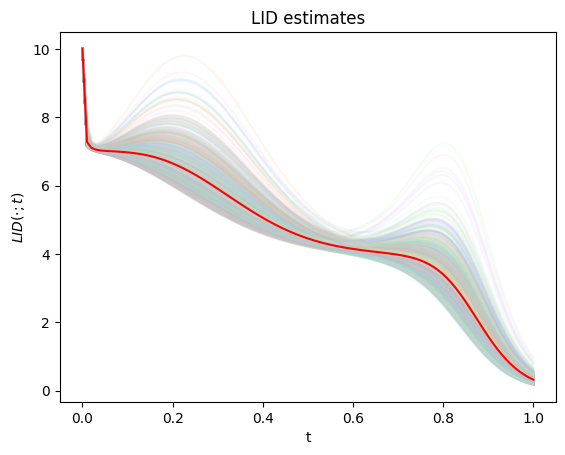

In [3]:

lid_estimator = FlipdEstimator(
    model=vpsde,
    ambient_dim=10,
    device=device,
)

plot_lid_trend_simple(
    data=data,
    lid_estimator=lid_estimator,
    mode='without_preprocessing', # fokker-planck estimators do not need any preprocessing
    argument_name='t',
    argument_values=torch.linspace(0, 1, 100),
)

**Expected results**: The rapid Fokker Planck estimator should be able to capture the multiscaled LID, this means that it should first capture the LID of the eigenvalues above 1e-4, this should be shown by an initial kink at small values of 't'. Then, it should capture the LID of the eigenvalues above 1, this should be shown by a second kink at intermediate values of 't'. These kinks should be at values 8 and 3 respectively. 

The following code will do the same thing but for the regression-based Fokker Planck estimator:

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


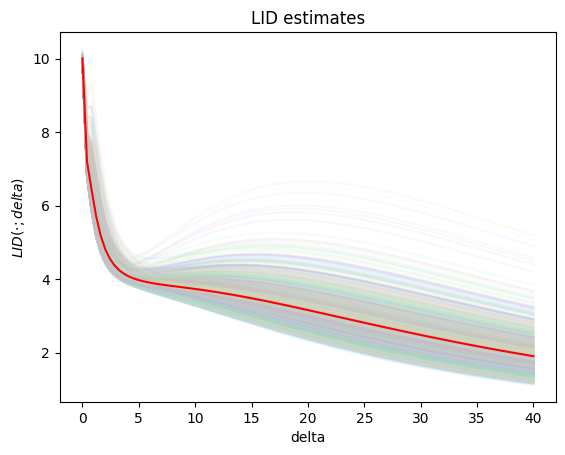

In [4]:
lid_estimator = FPRegressEstimator(
    model=vpsde,
    ambient_dim=10,
    device=device,
)

plot_lid_trend_simple(
    data=data,
    lid_estimator=lid_estimator,
    mode="without_preprocessing",  # fokker-planck estimators do not need any preprocessing
    argument_name="delta",
    argument_values=torch.linspace(0.001, 40, 100),
)

**Expected Result**: This will take some time but it should also provide the same result as before. However, this time the scale of the x-axis is different and is based on the standard deviation of the Gaussian convolution rather than the time 't'.

## Scenario 3: Train a score network on the Gaussian

Now instead of using the score network from the Gaussian analytical class, we sample data from the Gaussian and try to train a network on top of that distribution. Then, we will feed that to both of our FLIPD estimators:

In [15]:
%autoreload 2

from models.diffusions.networks import MLPUnet
from functools import partial
from torch import optim
from models.training import LightweightTrainer
from models.diffusions.training import LightningDiffusion

data = multiscale_distr.sample(
    100000,
    return_dict=False,
)
score_net = MLPUnet(
    data_dim=len(multiscale_distr.mean_vector),
    hidden_sizes=[4096, 2048, 1024, 1024, 512, 512],
    time_embedding_dim=128,
)

vpsde = VpSde(score_net=score_net).to(device)

training_module = LightningDiffusion(
    sde=vpsde,
    optim_partial=partial(optim.Adam, lr=1e-4),
)
trainer = LightweightTrainer(
    max_epochs=50,
    device=device,
)
trainer.fit(
    model=training_module,
    train_dataloader=torch.utils.data.DataLoader(data.to(device), batch_size=128),
    ckpt_path='outputs/notebooks/multiscale_gaussian/',
)
# The expected loss: < 4.25

Training epochs [Batch 781/782]: 100%|██████████| 50/50 [02:54<00:00,  5.83s/it, loss=4.23]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


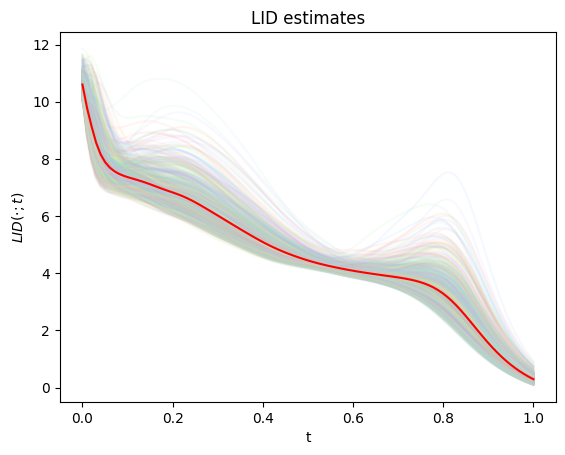

In [16]:

lid_estimator = FlipdEstimator(
    model=vpsde,
    ambient_dim=10,
    device=device,
)

plot_lid_trend_simple(
    data=data[:1000].to(device),
    lid_estimator=lid_estimator,
    mode='without_preprocessing', # fokker-planck estimators do not need any preprocessing
    argument_name='t',
    argument_values=torch.linspace(0, 1, 100),
)

**Expected results**: It should be roughly similar to doing the same thing with the Gaussian analytical class. However, the kink in the beginning this time around would not be as pronounced and sharp as before. This is because the score network is not perfect and there is some noise in the data. However, the kinks at the values of 8 and 3 should still be visible. You can potentially improve the kink if you train the model for a higher number of epochs.

100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


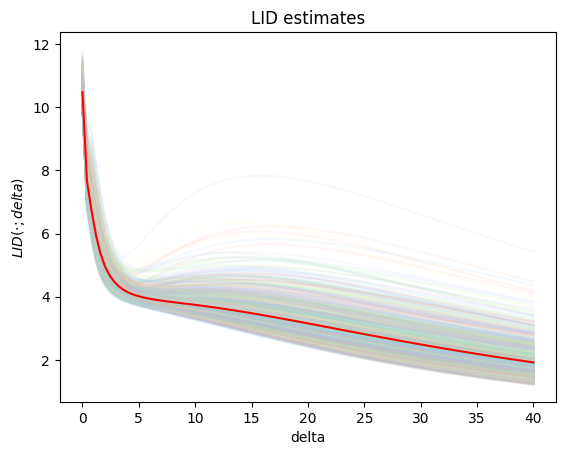

In [15]:
lid_estimator = FPRegressEstimator(
    model=vpsde,
    ambient_dim=10,
    device=device,
)

plot_lid_trend_simple(
    data=data[:1000].to(device),
    lid_estimator=lid_estimator,
    mode="without_preprocessing",  # fokker-planck estimators do not need any preprocessing
    argument_name="delta",
    argument_values=torch.linspace(0.001, 40, 100),
)

**Expected results**: It should also be roughly similar to the regression-based approach from before. However, the kinks at the values of 8 and 3 should still be visible. Again, you can potentially improve the kink if you train the model for a higher number of epochs.

## Scenario 2: Training a lollipop


In this example, we will train a model diffusion model first to fit a lollipop dataset, and then use the FLIPD estimator on that. This is a more realistic setting where we don't know the analytical solution. The following piece of code first generates the lollipop dataset and then trains a diffusion model on it.

In [17]:

%autoreload 2
from data.datasets.generated import LIDSyntheticDataset
from data.distributions import Lollipop

from models.diffusions.sdes import VpSde
from models.diffusions.networks import MLPUnet

dset = LIDSyntheticDataset(
    size=100000,
    distribution=Lollipop(),
    seed=42,
)

score_net = MLPUnet(2, hidden_sizes=(1024, 1024, 512, 512, 256, 128), time_embedding_dim=128).to(device)

sde = VpSde(score_net=score_net).to(device)


The main training loop:

In [19]:
training_module = LightningDiffusion(
    sde=sde,
    optim_partial=partial(optim.Adam, lr=1e-4),
)
trainer = LightweightTrainer(
    max_epochs=50,
    device=device,
)
trainer.fit(
    model=training_module,
    train_dataloader=torch.utils.data.DataLoader(dset.x.to(device), batch_size=128),
    ckpt_path='outputs/notebooks/lollipop/',
)

# The expected loss: < 0.4

Training epochs [Batch 1/782]:   0%|          | 0/50 [00:00<?, ?it/s]

Training epochs [Batch 781/782]: 100%|██████████| 50/50 [02:43<00:00,  3.28s/it, loss=0.389]


Let's see how the samples look:

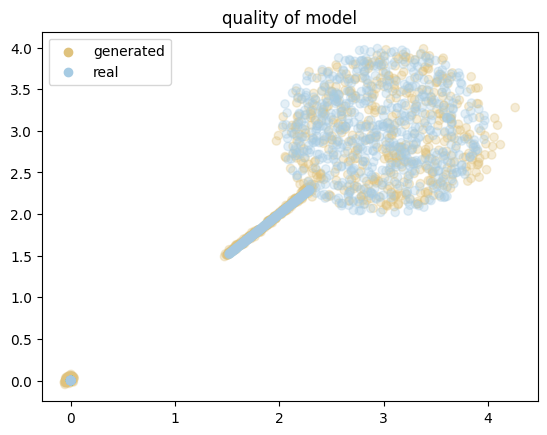

In [20]:
noise = torch.randn(1000, 2).to(device)
sde: VpSde
gen_samples = sde.solve_reverse_sde(noise, steps=1000)
from visualization import visualize_umap_clusters
from visualization.pretty import ColorTheme

visualize_umap_clusters(
    data = [gen_samples.cpu().detach().numpy(), dset.x[:1000].cpu().numpy()],
    labels=["generated", "real"],
    title="quality of model",
    alpha=0.3,
    colors=[ColorTheme.GOLD.value, ColorTheme.BLUE_SECOND.value],
    return_img=False,
)

**Expected Results**: The gold (model-generated) samples should roughly align with the blue ones, both representing a lollipop structure.

Let's see the LID estimates of the Rapid estimator by running the following block:

computing scatterplot: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


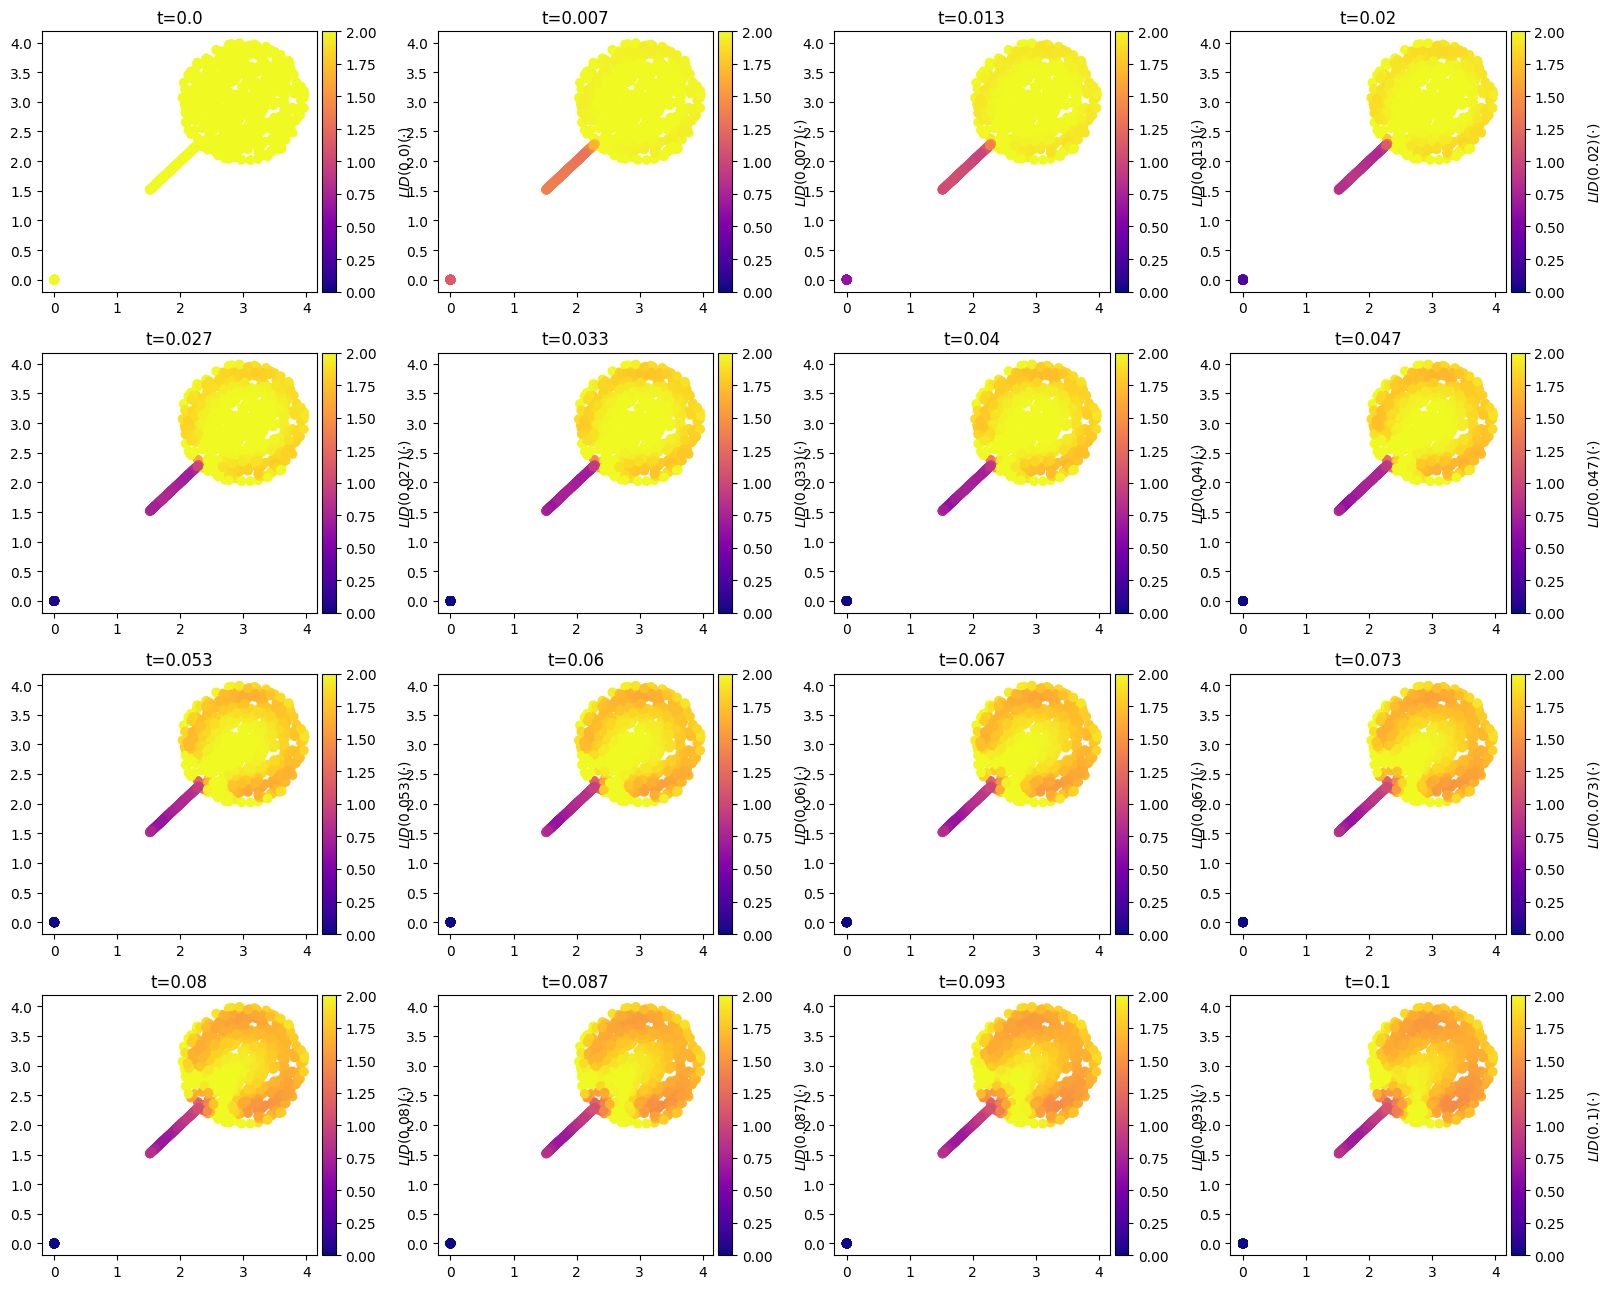

In [21]:
%autoreload 2
from visualization.notebook_utils import plot_lid_on_a_grid
import numpy as np
from lid.diffusions import FlipdEstimator

lid_estimator_rapid = FlipdEstimator(
    model=sde,
    ambient_dim=2,
    device=device,
)

plot_lid_on_a_grid(
    data=dset.x[:1000].to(device),
    lid_estimator=lid_estimator_rapid,
    mode='without_preprocessing', # fokker-planck estimators do not need any preprocessing
    argument_name='t',
    argument_values=np.linspace(0, 0.1, 16),
    method="deterministic",
    chunk_size=32,
    verbose=0,
)

**Expected Results** For very small values, the LID estimate should be equal to 'd' but as the time increases it decreases to 0. There is a sweet spot where the LID of each submanifold matches with its true intrinsic dimensionality, i.e., the point will have ID of 0, the stick will have ID of 1, and the candy is 2.

computing scatterplot: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


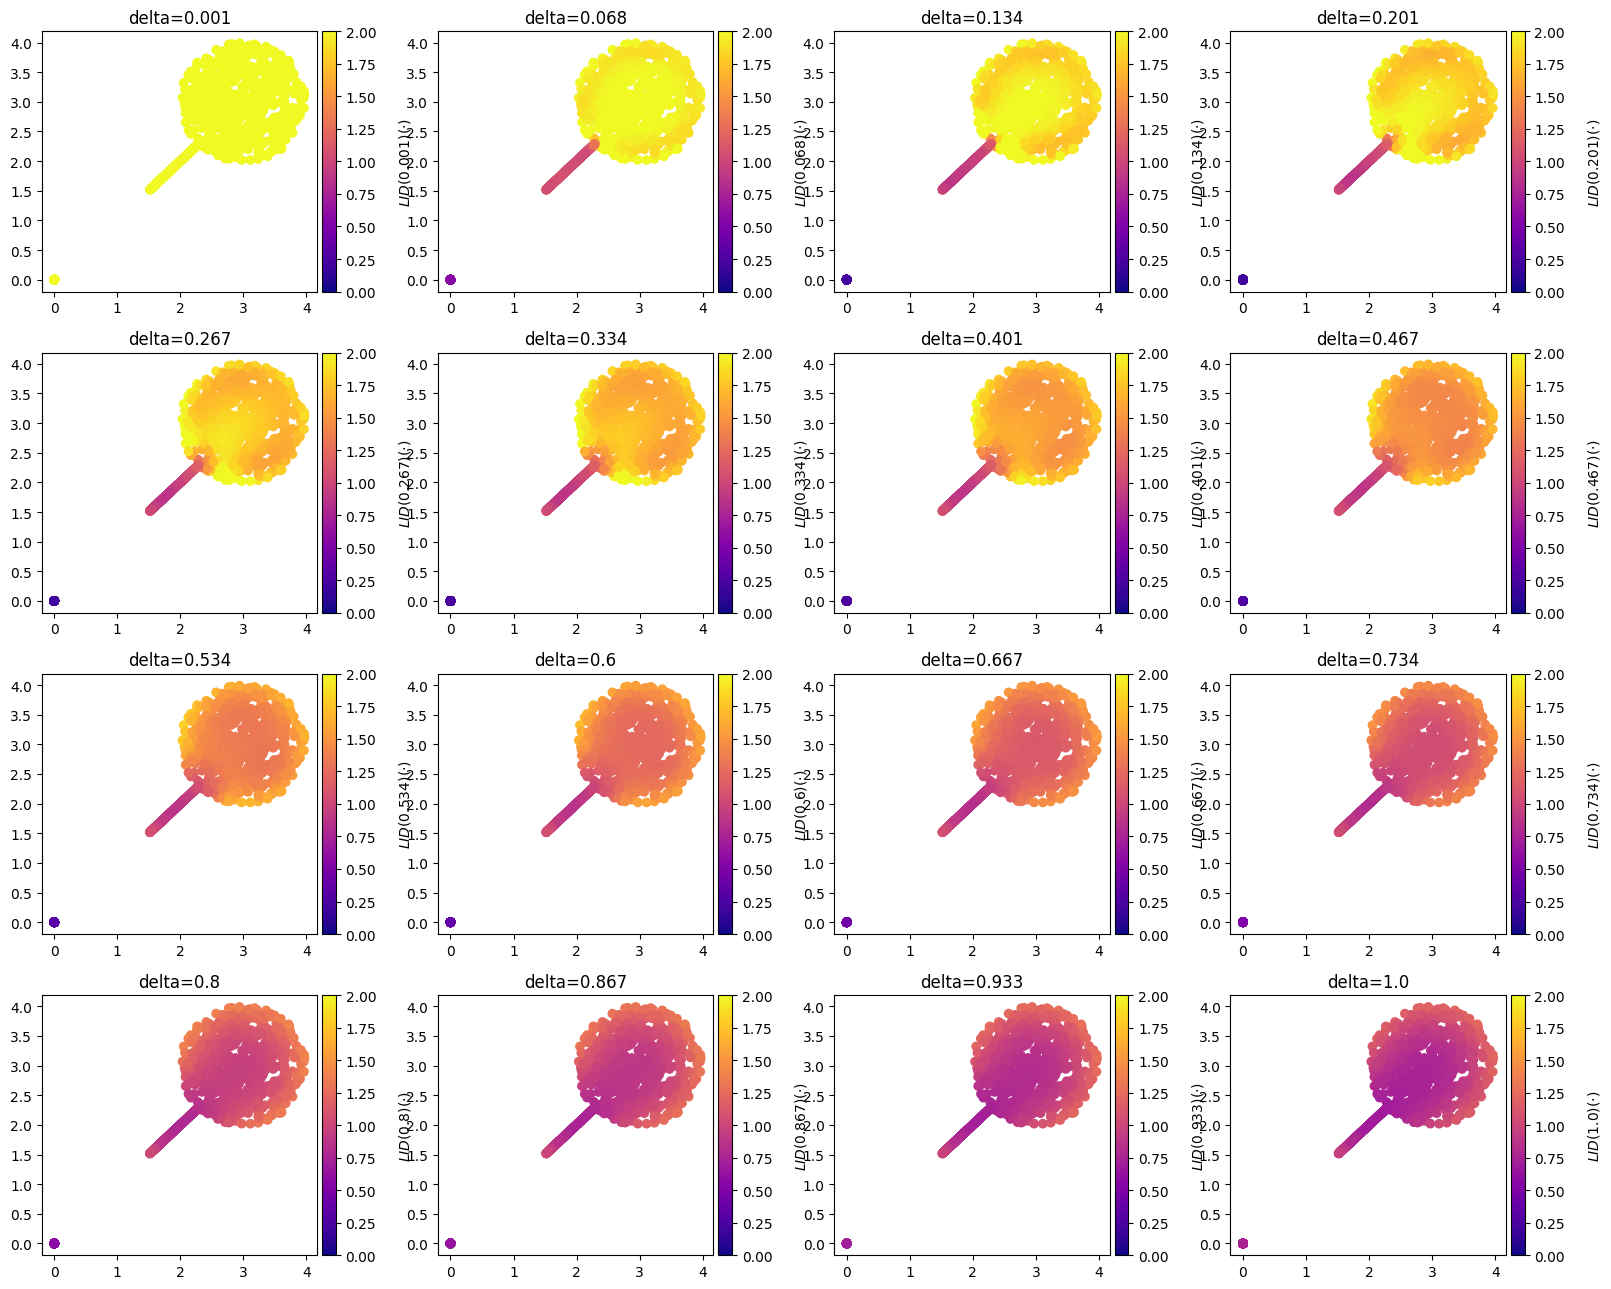

In [22]:
%autoreload 2
from visualization.notebook_utils import plot_lid_on_a_grid
import numpy as np
from lid.diffusions.fokker_planck import FPRegressEstimator

lid_estimator_regress = FPRegressEstimator(
    model=sde,
    ambient_dim=2,
    device=device,
)


plot_lid_on_a_grid(
    data=dset.x[:1000].to(device),
    lid_estimator=lid_estimator_regress,
    mode='without_preprocessing', # fokker-planck estimators do not need any preprocessing
    argument_name='delta',
    argument_values=np.linspace(0.001, 1, 16),
    method="deterministic",
    chunk_size=32,
    verbose=0,
)

**Expected Results** For very small values, the LID estimate should be equal to 'd' but as the time increases it decreases to 0. There is a sweet spot where the LID of each submanifold matches with its true intrinsic dimensionality, i.e., the point will have ID of 0, the stick will have ID of 1, and the candy is 2.